# Analysis for DataCrumbs

This is a simple analysis notebook for Datacrumbs.

## Imports

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import logging
import json
import dask
import os
from pathlib import Path
from glob import glob
import math
import zindex_py as zindex
import numpy as np
import intervals as I
import pandas as pd
from tqdm.notebook import trange, tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster, progress, wait, get_client
from dask.distributed import Future, get_client



## Project Variables

In [43]:
app_root = str(Path(os.getcwd()).parent)
is_trace = True
ops="write"
folder="/usr/workspace/haridev/xio/"
output=f"{folder}/output/jslines"
output_file=f"{output}/*.pfw.gz.jsonl"
analysis_files = glob(f"{output_file}")
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.StreamHandler(),
    ],
    format="%(asctime)s [%(levelname)s]: %(message)s in %(pathname)s:%(lineno)d",
)

## Setup Dask Local Cluster

In [44]:
workers=4
cluster = LocalCluster(n_workers=workers)  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default
logging.info(f"Initialized Client with {workers} workers and link {client.dashboard_link}")

2024-11-25 12:21:19,928 [INFO]: Initialized Client with 4 workers and link http://127.0.0.1:33329/status in /var/tmp/haridev/ipykernel_3683152/1637310826.py:4


## Start Analysis

In [45]:
function_mapping = { 
    "vfs" : {   
                "vfs_write", "__vfs_getxattr", "rw_verify_area", "__vfs_getxattr", "file_modified_flags", "file_modified", "vfs_read", "from_vfsgid", 
                "vfs_open", "from_vfsuid", 
    },
    "ext4": {   
                "__ext4_get_inode_loc", "__ext4_handle_dirty_metadata",
                "__ext4_journal_get_write_access", "__ext4_journal_start_sb", "__ext4_journal_stop", "__ext4_mark_inode_dirty", "ext4_block_write_begin",
                "ext4_buffered_write_iter", "ext4_cache_extents", "ext4_claim_free_clusters", "ext4_da_get_block_prep", "ext4_da_reserve_space",
                "ext4_da_write_begin", "ext4_da_write_end", "ext4_dirty_inode", "ext4_es_find_extent_range", "ext4_es_insert_delayed_block",
                "ext4_es_insert_extent", "ext4_es_lookup_extent", "ext4_ext_map_blocks", "ext4_fc_track_inode", "ext4_file_write_iter",
                "ext4_fill_raw_inode", "ext4_find_extent", "ext4_generic_write_checks", "ext4_get_group_desc", "ext4_get_inode_loc",
                "ext4_get_reserved_space", "ext4_has_free_clusters", "ext4_inode_csum", "ext4_inode_csum_set", "ext4_inode_table",
                "ext4_journal_check_start", "ext4_mark_iloc_dirty", "ext4_nonda_switch", "ext4_reserve_inode_write", "ext4_xattr_block_get",
                "ext4_xattr_get", "ext4_xattr_ibody_get", "ext4_xattr_security_get", "__ext4_ext_dirty", "ext4_block_bitmap",
                "ext4_block_bitmap_csum_set", "ext4_dio_alignment", "ext4_dio_write_checks", "ext4_dio_write_end_io", "ext4_dio_write_iter",
                "ext4_es_cache_extent", "ext4_es_delayed_clu", "ext4_ext_correct_indexes", "ext4_ext_find_goal", "ext4_ext_get_access",
                "ext4_ext_index_trans_blocks", "ext4_ext_insert_extent", "ext4_ext_next_allocated_block", "ext4_ext_search_left", "ext4_ext_search_right",
                "ext4_ext_try_to_merge", "ext4_ext_try_to_merge_right", "ext4_ext_try_to_merge_up", "ext4_fc_track_range", "ext4_free_group_clusters",
                "ext4_free_group_clusters_set", "ext4_get_group_info", "ext4_get_group_no_and_offset", "ext4_group_desc_csum", "ext4_group_desc_csum_set",
                "ext4_handle_inode_extension", "ext4_inode_block_valid", "ext4_inode_extension_cleanup", "ext4_inode_journal_mode", "ext4_inode_to_goal_block",
                "ext4_iomap_begin", "ext4_iomap_end", "ext4_map_blocks", "ext4_mb_collect_stats", "ext4_mb_find_by_goal",
                "ext4_mb_generate_buddy", "ext4_mb_generate_from_pa", "ext4_mb_good_group", "ext4_mb_good_group_nolock", "ext4_mb_init_cache",
                "ext4_mb_initialize_context", "ext4_mb_load_buddy_gfp", "ext4_mb_mark_diskspace_used", "ext4_mb_new_blocks", "ext4_mb_pa_put_free",
                "ext4_mb_prefetch", "ext4_mb_prefetch_fini", "ext4_mb_regular_allocator", "ext4_mb_simple_scan_group", "ext4_mb_unload_buddy",
                "ext4_mb_use_best_found", "ext4_meta_trans_blocks", "ext4_orphan_add", "ext4_orphan_del", "ext4_read_block_bitmap",
                "ext4_read_block_bitmap_nowait", "ext4_sb_block_valid", "ext4_set_iomap", "ext4_superblock_csum_set", "ext4_validate_block_bitmap",
                "ext4_wait_block_bitmap", "ext4_ext_determine_insert_hole", "__ext4_journal_get_create_access", "__read_extent_tree_block", "ext4_bg_has_super",
                "ext4_block_bitmap_csum_verify", "ext4_ext_grow_indepth", "ext4_extent_block_csum_set", "ext4_free_clusters_after_init", "ext4_get_group_number",
                "ext4_group_desc_csum_verify", "ext4_init_block_bitmap", "ext4_inode_bitmap", "ext4_mark_bitmap_end", "ext4_mb_complex_scan_group",
                "ext4_new_meta_blocks", "ext4_num_base_meta_blocks", "ext4_num_overhead_clusters", "ext4_read_bh_nowait", "ext4_valid_block_bitmap",
                "ext4_mb_check_limits", "ext4_mb_mark_pa_deleted", "ext4_mb_new_group_pa", "ext4_mb_new_inode_pa", "ext4_mb_use_inode_pa",
                "ext4_block_write_begin", "ext4_buffered_write_iter", "ext4_da_get_block_prep", "ext4_da_reserve_space", "ext4_da_write_begin",
                "ext4_da_write_end", "ext4_es_insert_delayed_block", "ext4_get_reserved_space", "ext4_nonda_switch", "ext4_mb_generate_buddy",
                "ext4_mb_generate_from_pa", "ext4_mb_init_cache", "ext4_ext_determine_insert_hole", "ext4_bg_has_super", "ext4_block_bitmap_csum_verify",
                "ext4_free_clusters_after_init", "ext4_group_desc_csum_verify", "ext4_init_block_bitmap", "ext4_inode_bitmap", "ext4_mark_bitmap_end",
                "ext4_num_base_meta_blocks", "ext4_num_overhead_clusters", "ext4_read_bh_nowait", "ext4_valid_block_bitmap","ext4_file_read_iter", 
                "ext4_setattr", "ext4_ext_remove_space", "ext4_set_inode_flags", "ext4_es_remove_extent","ext4_insert_dentry", "ext4_lookup", "__ext4_find_entry", "ext4_put_io_end_defer", "ext4_init_acl",
                 "ext4_validate_inode_bitmap", "ext4_bread_batch", "ext4_free_inodes_count", "__ext4_check_dir_entry",  "ext4_read_inode_bitmap", "ext4_get_dummy_policy", "ext4_itable_unused_count", "ext4_fname_setup_filename", 
                "ext4_ext_tree_init", "ext4_da_release_space", "ext4_free_inodes_set", "ext4_free_blocks", "ext4_match", "ext4_es_init_tree", "ext4_handle_dirty_dirblock", "ext4_init_pending_tree", "ext4_inode_bitmap_csum_set",
                "ext4_itable_unused_set", "expand_files", "ext4_search_dir", "ext4_remove_blocks", "ext4_file_open", "ext4_ext_truncate", "ext4_fname_prepare_lookup", "ext4_sample_last_mounted", "ext4_es_free_extent", "ext4_ext_rm_leaf",
                "ext4_break_layouts", "ext4_invalidate_folio", "__ext4_journal_ensure_credits", "ext4_end_bio",  "ext4_mb_clear_bb", "ext4_fname_from_fscrypt_name", "__ext4_xattr_set_credits",
                "ext4_find_dest_de", "init_file", "__ext4_new_inode", "ext4_create", "__ext4_read_dirblock", "ext4_add_nondir", "ext4_alloc_inode", "ext4_datasem_ensure_credits", "ext4_inode_attach_jinode", 
                "ext4_discard_preallocations", "ext4_fc_track_create", "ext4_getblk", "__ext4_ext_check", "ext4_bread", "ext4_init_security", "ext4_add_entry", "ext4_writepage_trans_blocks", "ext4_fc_init_inode",
                "ext4_set_aops", "ext4_release_folio", "ext4_fname_setup_ci_filename", "ext4_mb_free_metadata", "ext4_fname_free_filename", "ext4_truncate"
    },
    "page_cache": {"__alloc_pages", "__filemap_add_folio", "__filemap_get_folio", "__find_get_block", "__free_pages", "__jbd2_journal_file_buffer", "__mod_lruvec_page_state", "__mod_node_page_state", "__mod_zone_page_state",
                   "alloc_pages", "balance_dirty_pages", "balance_dirty_pages_ratelimited", "block_write_end", "filemap_add_folio", "filemap_alloc_folio", "filemap_get_entry", "free_tail_page_prepare", "free_unref_page",
                   "free_unref_page_commit","free_unref_page_list", "free_unref_page_prepare", "get_page_from_freelist", "mark_buffer_dirty", "prep_compound_page", "__find_get_block_slow", "bvec_try_merge_page", "filemap_check_errors",
                   "internal_get_user_pages_fast", "invalidate_inode_pages2_range", "jbd2_journal_file_inode", "pagecache_get_page", "__block_commit_write", "alloc_pages_mpol", "get_pfnblock_flags_mask", "page_mapping", "__get_free_pages",
                   "__filemap_add_folio", "__free_pages", "balance_dirty_pages", "balance_dirty_pages_ratelimited", "block_write_end", "filemap_add_folio",
                   "filemap_alloc_folio", "free_tail_page_prepare", "free_unref_page_commit", "free_unref_page_prepare", "mark_buffer_dirty", "prep_compound_page", "alloc_pages_mpol",
                   "page_mapping", "__update_load_avg_blocked_se", "page_counter_cancel", "page_counter_uncharge","should_fail_alloc_page","follow_page_pte", "follow_page_mask",
                    "do_anonymous_page","make_vfsgid", "mark_page_accessed", "__get_user_pages", "make_vfsuid", "try_grab_page", "balance_dirty_pages_ratelimited_flags", "unlock_page", "filemap_free_folio", 
                     "jbd2_journal_blocks_per_page", "dax_layout_busy_page", "block_invalidate_folio", "hook_file_truncate", "mod_zone_page_state",  "filemap_unaccount_folio",  "hook_file_open", "truncate_pagecache", "dax_layout_busy_page_range", "filemap_release_folio",
                     "alloc_empty_file", "delete_from_page_cache_batch", }, 
    "vm": {"mod_node_page_state", "node_page_state", "vm_normal_page"},
    "profile": {"profile_tick"},
    "file_cache": {"file_free_rcu","filemap_get_pages", "generic_file_read_iter", "filemap_get_read_batch", "filemap_read","generic_file_open",},
    "sched": {"__update_blocked_fair", "__update_load_avg_blocked_se", },
    "mount": {"__mnt_drop_write_file", "__mnt_want_write_file", "mnt_get_write_access_file", "mnt_put_write_access_file", "mnt_get_write_access_file", "mnt_put_write_access_file", },
    "dentry": {"__file_remove_privs",},
    "ima": {"ima_file_check",},
    "security": {"security_file_open",  "hook_file_alloc_security", "security_file_truncate","security_file_alloc", },
    "apparmor": {"aa_file_perm", "apparmor_file_permission", "security_file_permission", "apparmor_file_truncate", "apparmor_file_open", "apparmor_file_alloc_security",},
    "crypto": {"chacha_block_generic", "fscrypt_limit_io_blocks", "fscrypt_set_bio_crypt_ctx", "fscrypt_set_bio_crypt_ctx_bh", "fscrypt_set_bio_crypt_ctx_bh", "fscrypt_setup_filename", "fscrypt_file_open", },
    "memory": {"do_numa_page", "obj_cgroup_uncharge_pages", "page_counter_cancel", "page_counter_try_charge", "page_counter_uncharge", "release_pages", "lockless_pages_from_mm", "do_numa_page", "file_ra_state_init", "truncate_inode_pages_range", },
    "bio": {"__bio_add_page", "__bio_advance", "__bio_clone", "__bio_iov_iter_get_pages", "__bio_release_pages", "__bio_split_to_limits", "__blk_bios_map_sg", "__rq_qos_done_bio", "__submit_bio", "bio_alloc_bioset", "bio_associate_blkg",
            "bio_associate_blkg_from_css", "bio_attempt_back_merge", "bio_chain", "bio_clone_blkg_association", "bio_associate_blkg", "bio_associate_blkg_from_css", "bio_attempt_back_merge", "bio_chain", "bio_clone_blkg_association",
            "bio_crypt_ctx_mergeable", "bio_crypt_rq_ctx_compatible", "bio_endio", "bio_free", "bio_integrity_prep", "bio_iov_iter_get_pages", "bio_put", "bio_split", "bio_split_rw", "bio_to_wbt_flags",
            "bio_uninit", "blk_cgroup_bio_start", "blk_integrity_merge_bio", "blk_mq_attempt_bio_merge", "blk_mq_sched_bio_merge", "blk_mq_submit_bio","dd_bio_merge", "elv_bio_merge_ok", "iomap_dio_bio_end_io", "iomap_dio_bio_iter", 
            "iomap_dio_submit_bio", "should_fail_bio", "submit_bio", "submit_bio_noacct", "submit_bio_noacct_nocheck", "guard_bio_eod", "blk_account_io_merge_bio", "__bio_advance", "__bio_clone", "__bio_release_pages",
            "__rq_qos_done_bio", "bio_chain", "bio_clone_blkg_association", "bio_chain", "bio_clone_blkg_association", "bio_endio", "bio_free", "bio_put", "bio_uninit", "elv_bio_merge_ok", "iomap_dio_bio_end_io", "guard_bio_eod",
            "bio_set_pages_dirty", },
    "quota": {"dquot_file_open", },
    "block": {"kblockd_mod_delayed_work_on", "mb_find_order_for_block", "__block_commit_write", "get_pfnblock_flags_mask", "kblockd_mod_delayed_work_on","update_blocked_averages", "set_pfnblock_flags_mask"},
    "direct-io": {"kiocb_invalidate_pages", "pin_user_pages_fast", "unpin_user_page"}
}

In [67]:
def load_trace(trace):
    return dd.read_json(trace)

def load_traces(regex_file):
    files = glob(f"{regex_file}")
    final_dataset_l = []
    for file in files:
        final_dataset_l.append(load_trace(file))
    final_dataset = dd.concat(final_dataset_l).compute().reset_index().drop("index", axis=1)
    return final_dataset

def clean_data(ddf):
    return ddf.fillna(value=0.0)

def flatten_mapped_function(function_mapping):
    all_mapped_functions = set()
    for key, value in function_mapping.items():
        all_mapped_functions.update(value)
    return all_mapped_functions

def get_missed_mapping(ddf, all_mapped_functions):
    missed_mapping = set()
    for column in ddf.columns:
        values = column.split("-")
        if len(values) > 1 and values[0] not in all_mapped_functions:
            # print(values[0])
            missed_mapping.add(values[0])
    return missed_mapping

def print_mapping(missed_mapping):
    for index, col in enumerate(missed_mapping):
        if index % 10 == 9:
            print(f"\"{col}\",")
        else:
            print(f"\"{col}\", ", end="")
            
def find_most_related_functions(category, ddf, columns, variance_target):
    ignore_columns = ["write-sys","main", "read-sys","write","open64","open", ]
    y_columns = ["BW"]
    x_columns = []
    for column in columns:
        if column not in ignore_columns:
            col = ddf.columns[ddf.columns.str.contains(column)]
            if len(col) > 0:
                x_columns.append(col[0])
    # print(x_columns)
    if len(x_columns) < 1:
        return 0, 0, [], (0, 0, 0)
    x = ddf.loc[:, x_columns].values
    y = ddf.loc[:, y_columns].values
    regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
    _ = regressor.fit(x, y.ravel())
    oob_score = regressor.oob_score_
    # print(f'Out-of-Bag Score: {oob_score}')

    # Making predictions on the same data or new data
    predictions = regressor.predict(x)

    # Evaluating the model
    mse = mean_absolute_percentage_error(y, predictions)
    # print(f'Mean Squared Error: {mse}')

    r2 = r2_score(y, predictions)
    # print(f'R-squared: {r2}')
    
    f_i = list(zip(x_columns,regressor.feature_importances_))
    f_i.sort(reverse=True, key = lambda x : x[1])
    variances = [x[1] for x in f_i]
    required_values = (np.cumsum(variances)<=variance_target).argmin() + 1
    most_f_i = f_i[:required_values]
    most_important_features = [x[0].split("-")[0] for x in most_f_i]
    most_important_variances = [x[1] for x in most_f_i]
    indices = np.argsort(most_important_variances).astype(int)
    print(most_important_variances)
    # print(indices)
    print(most_important_features)
    # from matplotlib.pyplot import figure
    # import matplotlib
    # figure(figsize=(8, 4), dpi=80)
    # font = {'size'   : 14}

    # matplotlib.rc('font', **font)
    # plt.title('Feature Importances')
    # plt.barh(range(len(indices)), most_important_variances, color='b', align='center')
    # plt.yticks(range(len(indices)), [most_important_features[i] for i in indices])
    # plt.xlabel('Relative Importance')
    # plt.show()
    # print(category, np.sum(variances[:required_values]), required_values, most_important_features)
    return np.sum(variances[:required_values]), required_values, most_important_features, (oob_score, mse, r2)


### Check for missed Mapping

In [68]:
all_mapped_functions = flatten_mapped_function(function_mapping)

for trace in analysis_files:
    print(f"\n\nChecking missed mapping for dataset {trace}")
    ddf = load_trace(trace)
    missed_mapping = get_missed_mapping(ddf, all_mapped_functions)
    print_mapping(missed_mapping)



Checking missed mapping for dataset /usr/workspace/haridev/xio//output/jslines/write_ops-64_ts-64m-RAW-DIRECT.pfw.gz.jsonl
"write", 

Checking missed mapping for dataset /usr/workspace/haridev/xio//output/jslines/write_ops-32_files-8-RAW-BUF.pfw.gz.jsonl


Checking missed mapping for dataset /usr/workspace/haridev/xio//output/jslines/write_ops-32_files-8-RAW-DIRECT.pfw.gz.jsonl


Checking missed mapping for dataset /usr/workspace/haridev/xio//output/jslines/read_ops-32_files-8-RAW-DIRECT.pfw.gz.jsonl
"main", 

Checking missed mapping for dataset /usr/workspace/haridev/xio//output/jslines/read_ops-32_files-8-RAW-BUF.pfw.gz.jsonl
"main", 

Checking missed mapping for dataset /usr/workspace/haridev/xio//output/jslines/openat_ops-32_files-8-RAW-BUF.pfw.gz.jsonl
"main", "open64", "open", 

Checking missed mapping for dataset /usr/workspace/haridev/xio//output/jslines/write_ops-64_ts-64m-RAW-BUFFERED.pfw.gz.jsonl
"write", 

### Build a ML model

In [72]:

variance_target = 0.97
min_variance_target = 0
final_relevant_columns = set()
for trace in ["/usr/workspace/haridev/xio//output/jslines/write_ops-32_files-8-RAW-BUF.pfw.gz.jsonl"]:
    
    print(f"\n\nCreating model for dataset {trace}")
    ddf = load_trace(trace)
    ddf = clean_data(ddf).compute()
    # print(ddf)
    for category, columns in function_mapping.items():
        if category == "page_cache":
            explained_variance, number_of_features, features, model_parameters = find_most_related_functions(category, ddf, columns, variance_target)
            #if number_of_features > 0 and min_variance_target <= explained_variance:
            print(f"{number_of_features: >3} / {len(columns): >3} important features in {category: >10} gives variance:{explained_variance*100.0:>6,.2f}% r2:{model_parameters[2]:>3,.2f} mape:{model_parameters[1]:>10,.2f} group with {features}")
            # break
            final_relevant_columns.update(set(features))

print(f"Total relevant features are {len(final_relevant_columns)}")




Creating model for dataset /usr/workspace/haridev/xio//output/jslines/write_ops-32_files-8-RAW-BUF.pfw.gz.jsonl
[np.float64(0.25208168703739164), np.float64(0.06342193760406092), np.float64(0.06226488368802875), np.float64(0.061063599659989413), np.float64(0.0589495604201136), np.float64(0.056056662241074494), np.float64(0.054929511189094754), np.float64(0.050450339965618075), np.float64(0.046605630719708406), np.float64(0.04655829026586008), np.float64(0.044339663442204275), np.float64(0.0430772358506388), np.float64(0.033360271597302746), np.float64(0.03190564427117441), np.float64(0.030972728554498175), np.float64(0.021172550346894723), np.float64(0.014618431618400261)]
['get_page_from_freelist', '__filemap_get_folio', '__alloc_pages', 'mark_buffer_dirty', '__filemap_add_folio', 'filemap_alloc_folio', '__mod_node_page_state', '__mod_lruvec_page_state', '__alloc_pages', '__find_get_block', 'filemap_get_entry', '__mod_zone_page_state', '__filemap_add_folio', 'balance_dirty_pages_rat

Creating model for all datasets


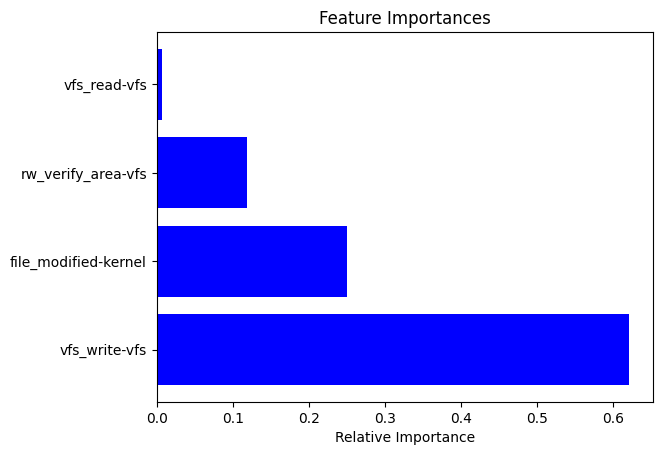

  4 /   9 important features in        vfs gives variance: 99.67% r2:0.97 mape:      0.17 


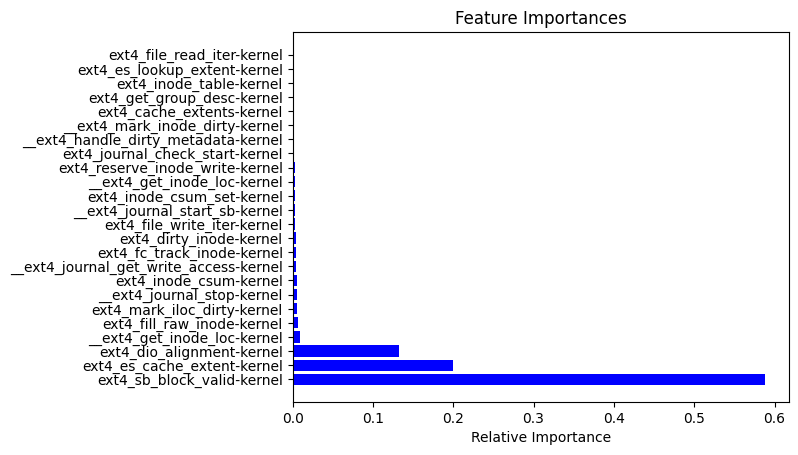

 24 / 195 important features in       ext4 gives variance: 99.04% r2:0.90 mape:644,458,346,775.08 


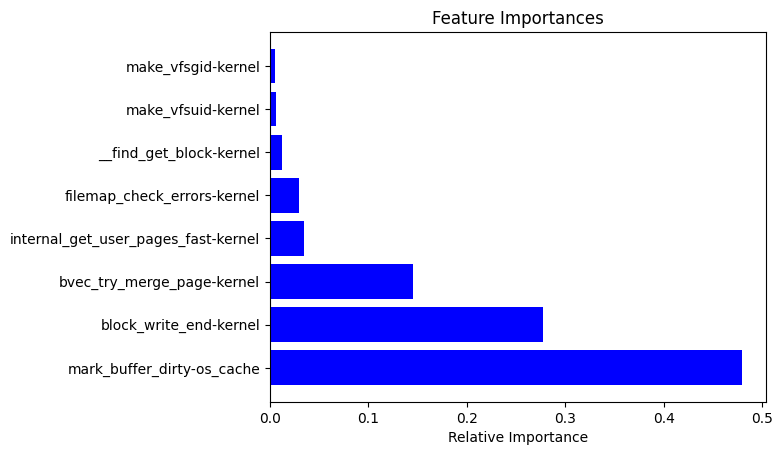

  8 /  63 important features in page_cache gives variance: 99.03% r2:0.92 mape:      0.16 


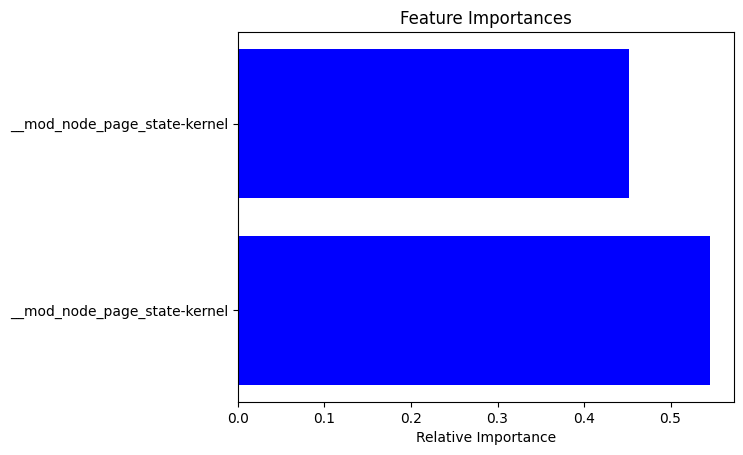

  2 /   3 important features in         vm gives variance: 99.83% r2:0.03 mape:269,134,177,061,929.91 


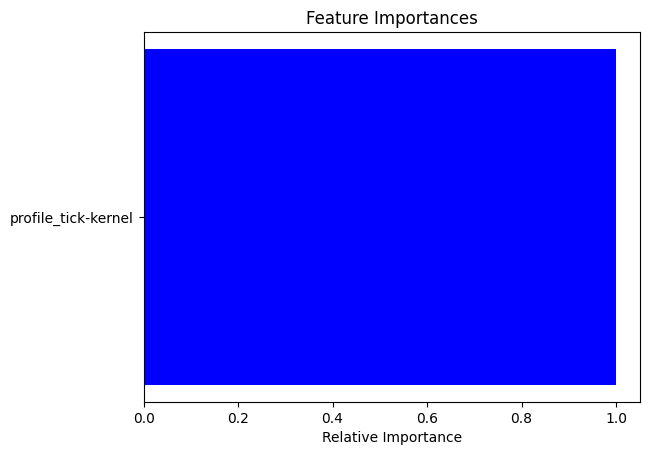

  1 /   1 important features in    profile gives variance:100.00% r2:0.00 mape:2,135,581,151,074,132.50 


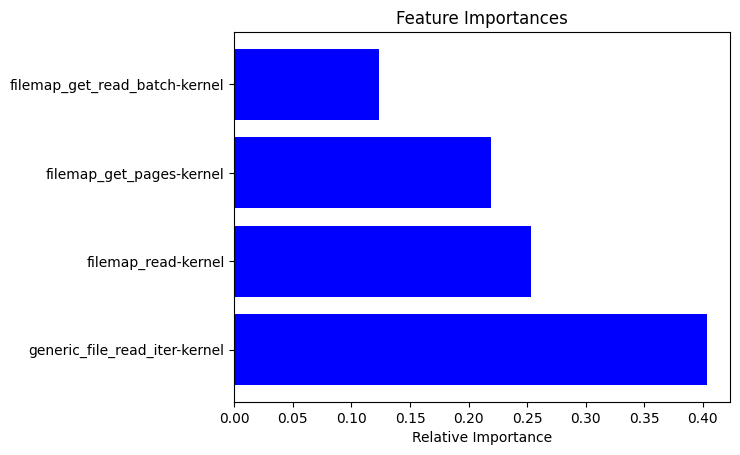

  4 /   6 important features in file_cache gives variance: 99.95% r2:0.95 mape:      1.22 


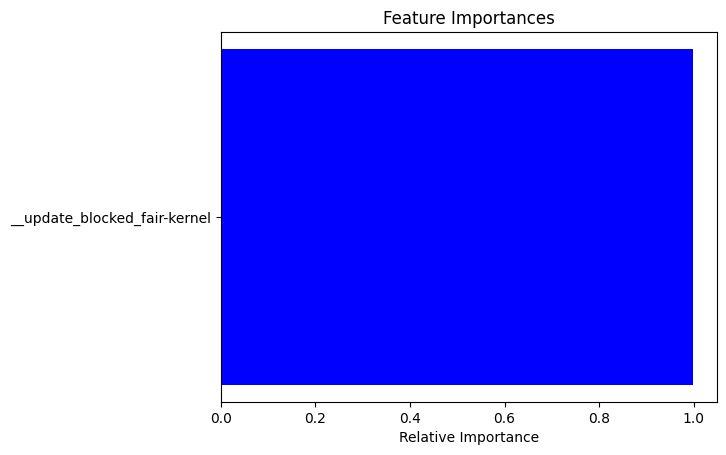

  1 /   2 important features in      sched gives variance: 99.85% r2:0.00 mape:2,448,190,913,318,968.50 


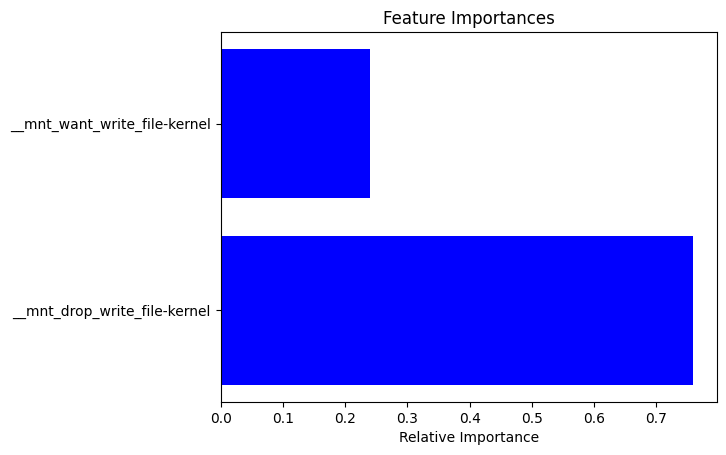

  2 /   4 important features in      mount gives variance: 99.80% r2:0.03 mape:2,907,466,409,796,931.50 


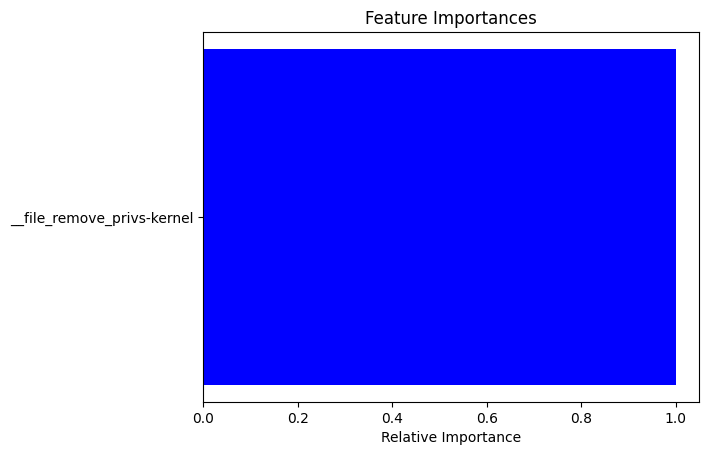

  1 /   1 important features in     dentry gives variance:100.00% r2:0.12 mape:4,102,043,887,920,672.50 


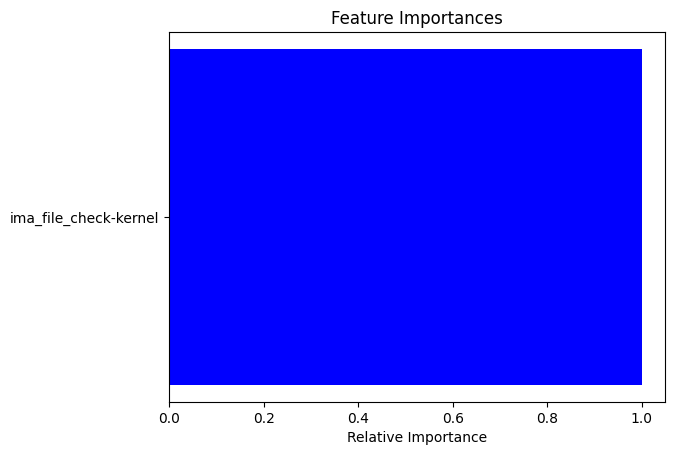

  1 /   1 important features in        ima gives variance:100.00% r2:0.00 mape:      3.39 


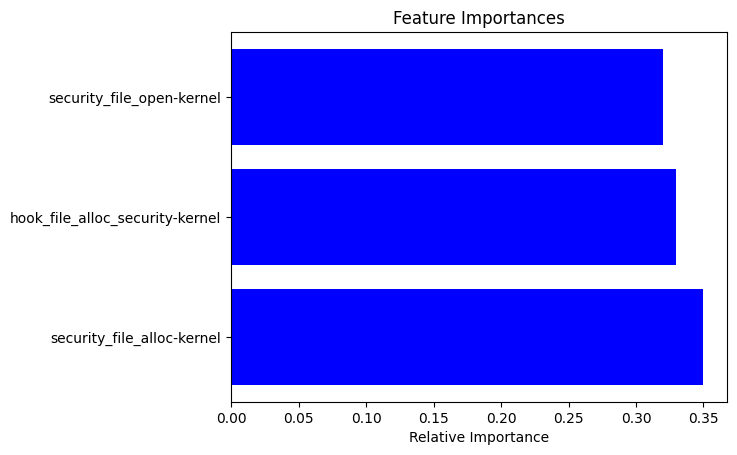

  3 /   4 important features in   security gives variance:100.00% r2:0.00 mape:      3.39 


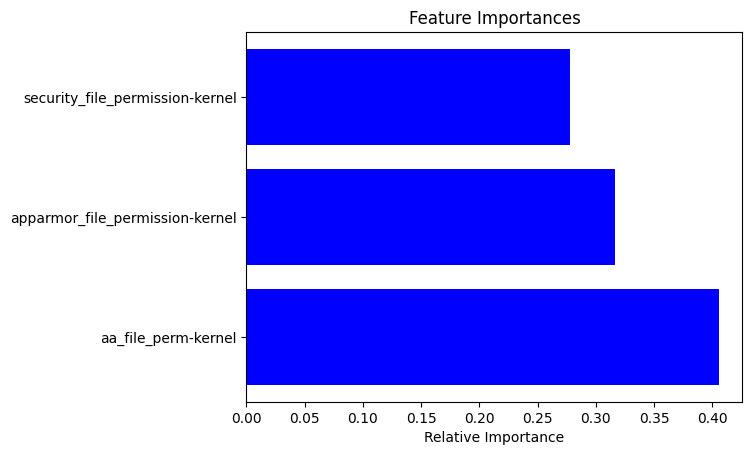

  3 /   6 important features in   apparmor gives variance: 99.99% r2:0.88 mape:      0.92 


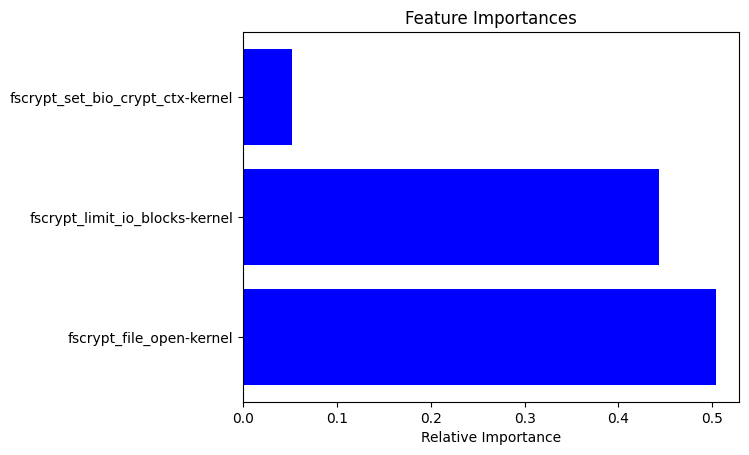

  3 /   6 important features in     crypto gives variance: 99.82% r2:0.11 mape:      2.20 


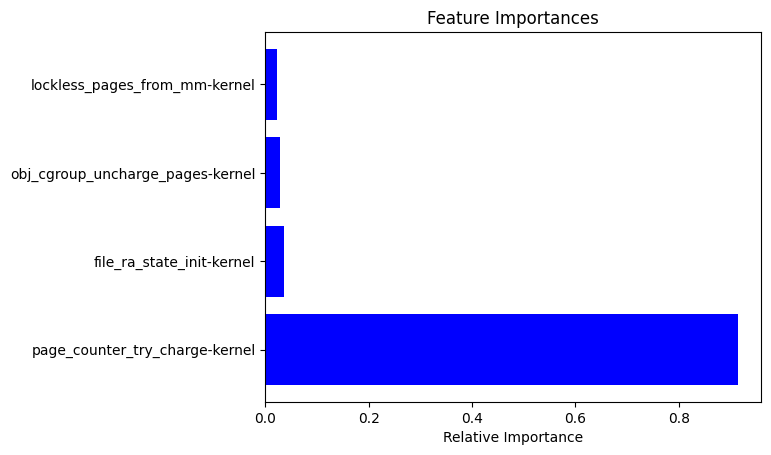

  4 /   9 important features in     memory gives variance:100.00% r2:0.12 mape:      2.03 


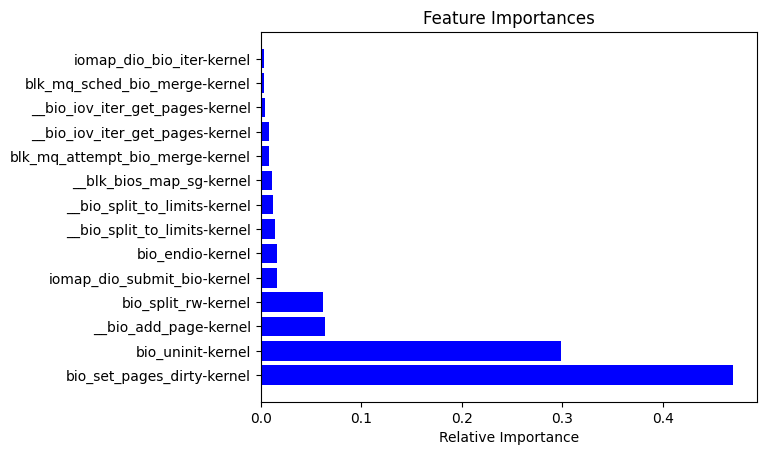

 14 /  43 important features in        bio gives variance: 99.23% r2:0.12 mape:2,528,482,948,274,780.50 


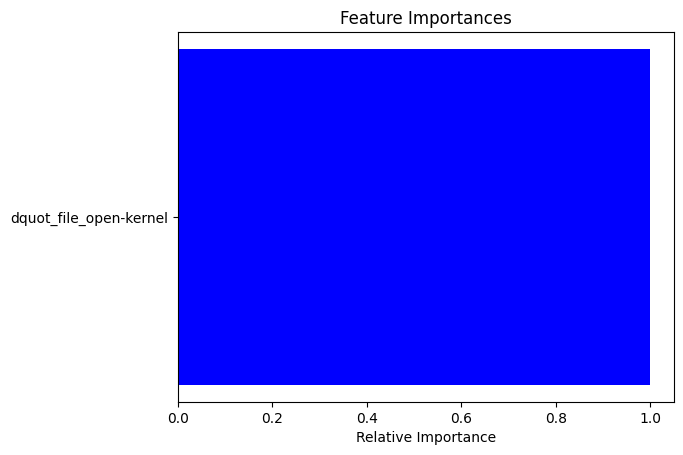

  1 /   1 important features in      quota gives variance:100.00% r2:0.00 mape:      3.39 


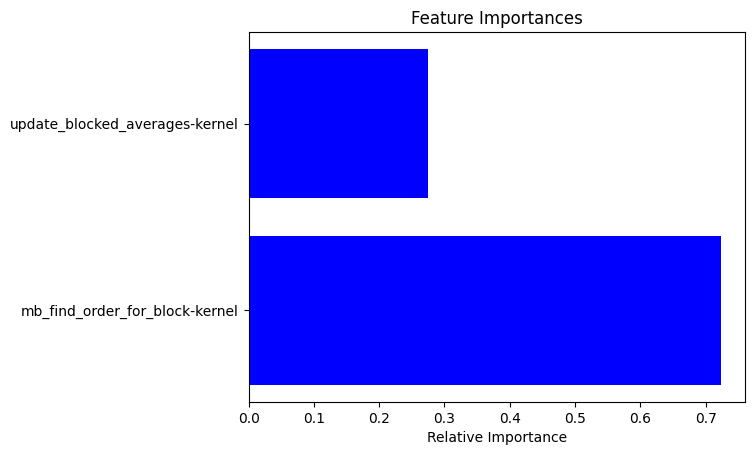

  2 /   6 important features in      block gives variance: 99.90% r2:0.00 mape:2,454,438,561,435,628.00 


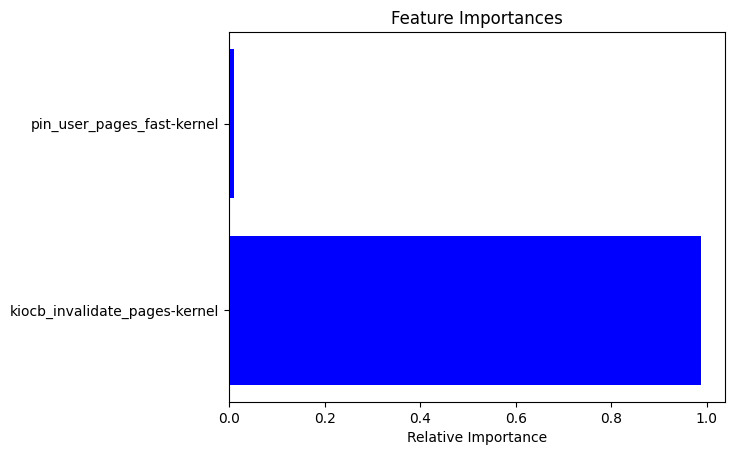

  2 /   3 important features in  direct-io gives variance: 99.92% r2:0.11 mape:3,957,355,232,226,828.00 


In [49]:

print(f"Creating model for all datasets")
ddf = load_traces(output_file)
ddf = clean_data(ddf)
# print(ddf)
for category, columns in function_mapping.items():
    explained_variance, number_of_features, features, model_parameters = find_most_related_functions(category, ddf, columns, variance_target)
    #if number_of_features > 0 and min_variance_target <= explained_variance:
    print(f"{number_of_features: >3} / {len(columns): >3} important features in {category: >10} gives variance:{explained_variance*100.0:>6,.2f}% r2:{model_parameters[2]:>3,.2f} mape:{model_parameters[1]:>10,.2f} ")# group with {features}")
    # break
    final_relevant_columns.update(set(features))

## make the number of relevance features dynamic.
1. Correlation
   1. correlation matrix.
   2. PCA
   3. Lasso Regression (L1)
   4. Auto regression
2. SHAPLEY value (feature importance)
   1. Tree SHAP
3. How portable are the interfaces (do not overfit)

1. Tanzima for better models


## models
- sequential training: gradient boost
- 